In [1]:
# <a href="https://colab.research.google.com/github/lphansen/RiskUncertaintyValue/blob/main/expansion_suite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robust Inattentive Discrete Choice
*Notebook written by Chun Hei Hung*

This notebook describes the code used to solve the following problem described in Section 5 of the paper:

$$
\max_{p \in \Delta(A|X),q \in \Delta(A)} \min_{\mu \in \Delta(X)} \sum_x{ \mu(x) \left[ G(p,q)(x)+\xi \log{\frac{\mu(x)}{\hat{\mu}(x)}}  \right] }
$$

Where:

$$
G(p,q)(x) = \sum_a{p(a|x)\left[u(x,a)-\lambda \log{\frac{p(a|x)}{q(a)}}\right]}
$$

Using the numerical algorithm from Section 3. It is divided into two sections: the first section applies the algorithm for a given set of $(\alpha,\lambda,\xi)$, while the second section constrains the information by $\kappa$ and calculates the optimal $\lambda$ for a given set $(\alpha,\xi)$.

```{contents}
:depth: 2
```

# 1 Base Case
## 1.1 Solution Code Overview

The function `solve` implements the numerical algorithm for a given set of parameters, and outputs the solution and related objects of interest.

First, the user should specify the values of $\alpha,\lambda,\xi$ over which `solve` should be evaluated. Each of these are arrays of type `float`. Each array can have different lengths.

```{list-table}
:header-rows: 1

* - Array
  - Domain restrictions
  - Description
  - Default
* - `alpha_array`
  - 0 to 1
  - Coefficient of risk aversion, where $\alpha=0$ is the *linear utility* and values close to $1$ approximate the *log utility* case
  - 10 evenly spaced points from 0 to 0.9
* - `Lam_array`
  - Greater or equal to 1 (less than 1 causes convergence issues)
  - Information cost, where large values, e.g. $\mathbb{I}=100$, approximate *zero information cost*
  - [10.0]
* - `xi_array`
  - Greater or equal to 1
  - Robustness parameter, where large values, e.g. $\mathbb{R}=100$, approximate *no robustness adjustment*
  - 10 evenly spaced points from 1 to 100
```
Second, the user should specify the following parameters:
```{list-table}
:header-rows: 1

* - Input
  - Type
  - Description
  - Default
* - `N`
  - *int*
  - Number of **states** 
  - 2
* - `M`
  - *int*
  - Number of **actions**
  - 3
* - `hat_mu`
  - $N \times 1$ *ndarray*
  - **Baseline prior**: does not affect the solution in this model
  - Uniform prior
* - `eps`
  - *float*
  - **Tolerance**: the higher the tolerance, the more accurate the solution but the longer the computation time. Tolerance of $10^{-6}$ or lower is recommended as a baseline
  - $10^{-6}$
* - `q_step`,`p_step`,`mu_step`
  - *float*
  - **Step-size**: for each variable $x \in \{p,q,\mu\}$ in the algorithm. The larger the step-size, the greater the adjustment from $x_t$ to $x_{t+1}$, with 1 meaning full adjustment. A larger step-size reduces the occurrence of convergence issues but increases computation time. Step-size of $0.1$ will ensure convergence for the parameters described in the paper
  - $0.1$
* - `payoff_set`
  - $M \times N$ *ndarray*
  - **Payoff matrix**: the dimensions of this input must be $(M,N)$. If the user wishes to use the payoff matrix specified in the paper parameterized by $r$, they can simply change $r$ without changing the payoff matrix
  - $[[0,2r],[r,0],[5,5]]$
```

`solve` generates the following outputs:
```{list-table}
:header-rows: 1

* - Output
  - Type
  - Description
  - Notation in manuscript
* - `objective`
  - *float*
  - Optimal value of **objective function** 
  - $\mathbb{E}[u(x,a)] - \lambda \mathbb{I} + \xi \mathbb{R}$ given $(p^*,q^*,\mu^*)$
* - `p`
  - $M \times N$ *ndarray*
  - **State-dependent decision rule**: entry $(i,j)$ of this array corresponds to the probability of choosing action $i$ given state $j$
  - $p^*(a|x)$
* - `q`
  - $M \times 1$ *ndarray*
  - **Worst-case marginal distribution** over actions
  - $q^*(a)$
* - `mu`
  - $N \times 1$ *ndarray*
  - **Worst-case prior**
  - $\mu^*$
* - `information`
  - *float*
  - Optimal value of **mutual information**
  - $\mathbb{I}(p^*,q^*)$
* - `entropy`
  - *float*
  - Optimal value of **relative entropy**
  - $\mathbb{R}(\mu^*,\hat{\mu})$ 
```


## 1.2 Quick Start
Let's start by importing the necessary Python libraries and functions.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from src import solve, plot, save_results

Next, we can specify the $(\alpha,\lambda,\xi)$ grid:

In [3]:
#Arrays
alpha_array = np.linspace(0.0,0.9, 10)
Lam_array = [10.0]
xi_array = np.linspace(1.0, 100.0, 10)

A, L, X = np.meshgrid(alpha_array, Lam_array, xi_array, indexing='ij')

#Initialize grid of results
results = np.zeros((len(alpha_array), len(Lam_array), len(xi_array)), dtype=object) 

Finally, we specify the parameters:

In [4]:
#Parameters
N = 2  # Number of states
M = 3  # Number of actions
r = 7.5 # Parameterization of the payoff set
payoff_set = np.array([[0.0, r * 2], [r, 0.0], [5.0, 5.0]]) # If you want to use the payoff matrix in the paper, do not change this variable; instead, change r
eps = 1e-6  # Error tolerance

# Time-step increments
q_step = 0.1
p_step = 0.1
mu_step = 0.1

# Baseline prior
hat_mu = np.ones(N)*(1/N) # Uniform prior 

# Check that payoff matrix is correctly specified
if payoff_set.shape != (M, N):
    raise ValueError("Payoff set must be of shape (M, N)")

# Collect parameters
params = [M, N, hat_mu, eps, q_step, p_step, mu_step,payoff_set]

Now we run `solve` at each point in our $\alpha,\lambda,\xi$ grid. Under the default settings, this takes 40 seconds.

In [5]:
for alpha in range(len(alpha_array)):
    for lam in range(len(Lam_array)):
        for xi in range(len(xi_array)):
            results[alpha,lam,xi] = solve(X[alpha,lam,xi], L[alpha,lam,xi], A[alpha,lam,xi], params)


KeyboardInterrupt: 

The user can save the results as a `pkl` file with name specified by `results_name` using the following code.

In [15]:
results_name = 'experiment1'
save_results(results_name, results, alpha_array, Lam_array, xi_array, params)

## 1.3 Plotting


The user can plot the results along a chosen axis, holding the other two axes fixed, using the code below. 

Specifying `axis` as 0 will plot the results with $\alpha$ on the $x$ axis; 1 will plot $\lambda$; and 2 will plot $\xi$. The other two variables will be fixed at the indices specified by `fixed_values`. For example, the default settings below plot the results with $\xi$ on the $x$ axis, with $\alpha$ and $\lambda$ fixed at the first entry of their respective arrays. The plot will automatically be saved in the `plots` folder under `plot_name`, which can be specified below.

/Users/chunheihung/BFI Dropbox/Chun Hei Hung/MFR_RP/rational_inattention/replication_package/sphinx/src.py:224: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-r" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(index, data2, '-r', linewidth=2, linestyle='dashed', label=label2)
/Users/chunheihung/BFI Dropbox/Chun Hei Hung/MFR_RP/rational_inattention/replication_package/sphinx/src.py:225: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-k" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(index, data3, '-k', linewidth=2, linestyle='dotted', label=label3)
/Users/chunheihung/BFI Dropbox/Chun Hei Hung/MFR_RP/rational_inattention/replication_package/sphinx/src.py:228: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-r" (-> linestyle='-'). The keyword argument will take precedence.
  a

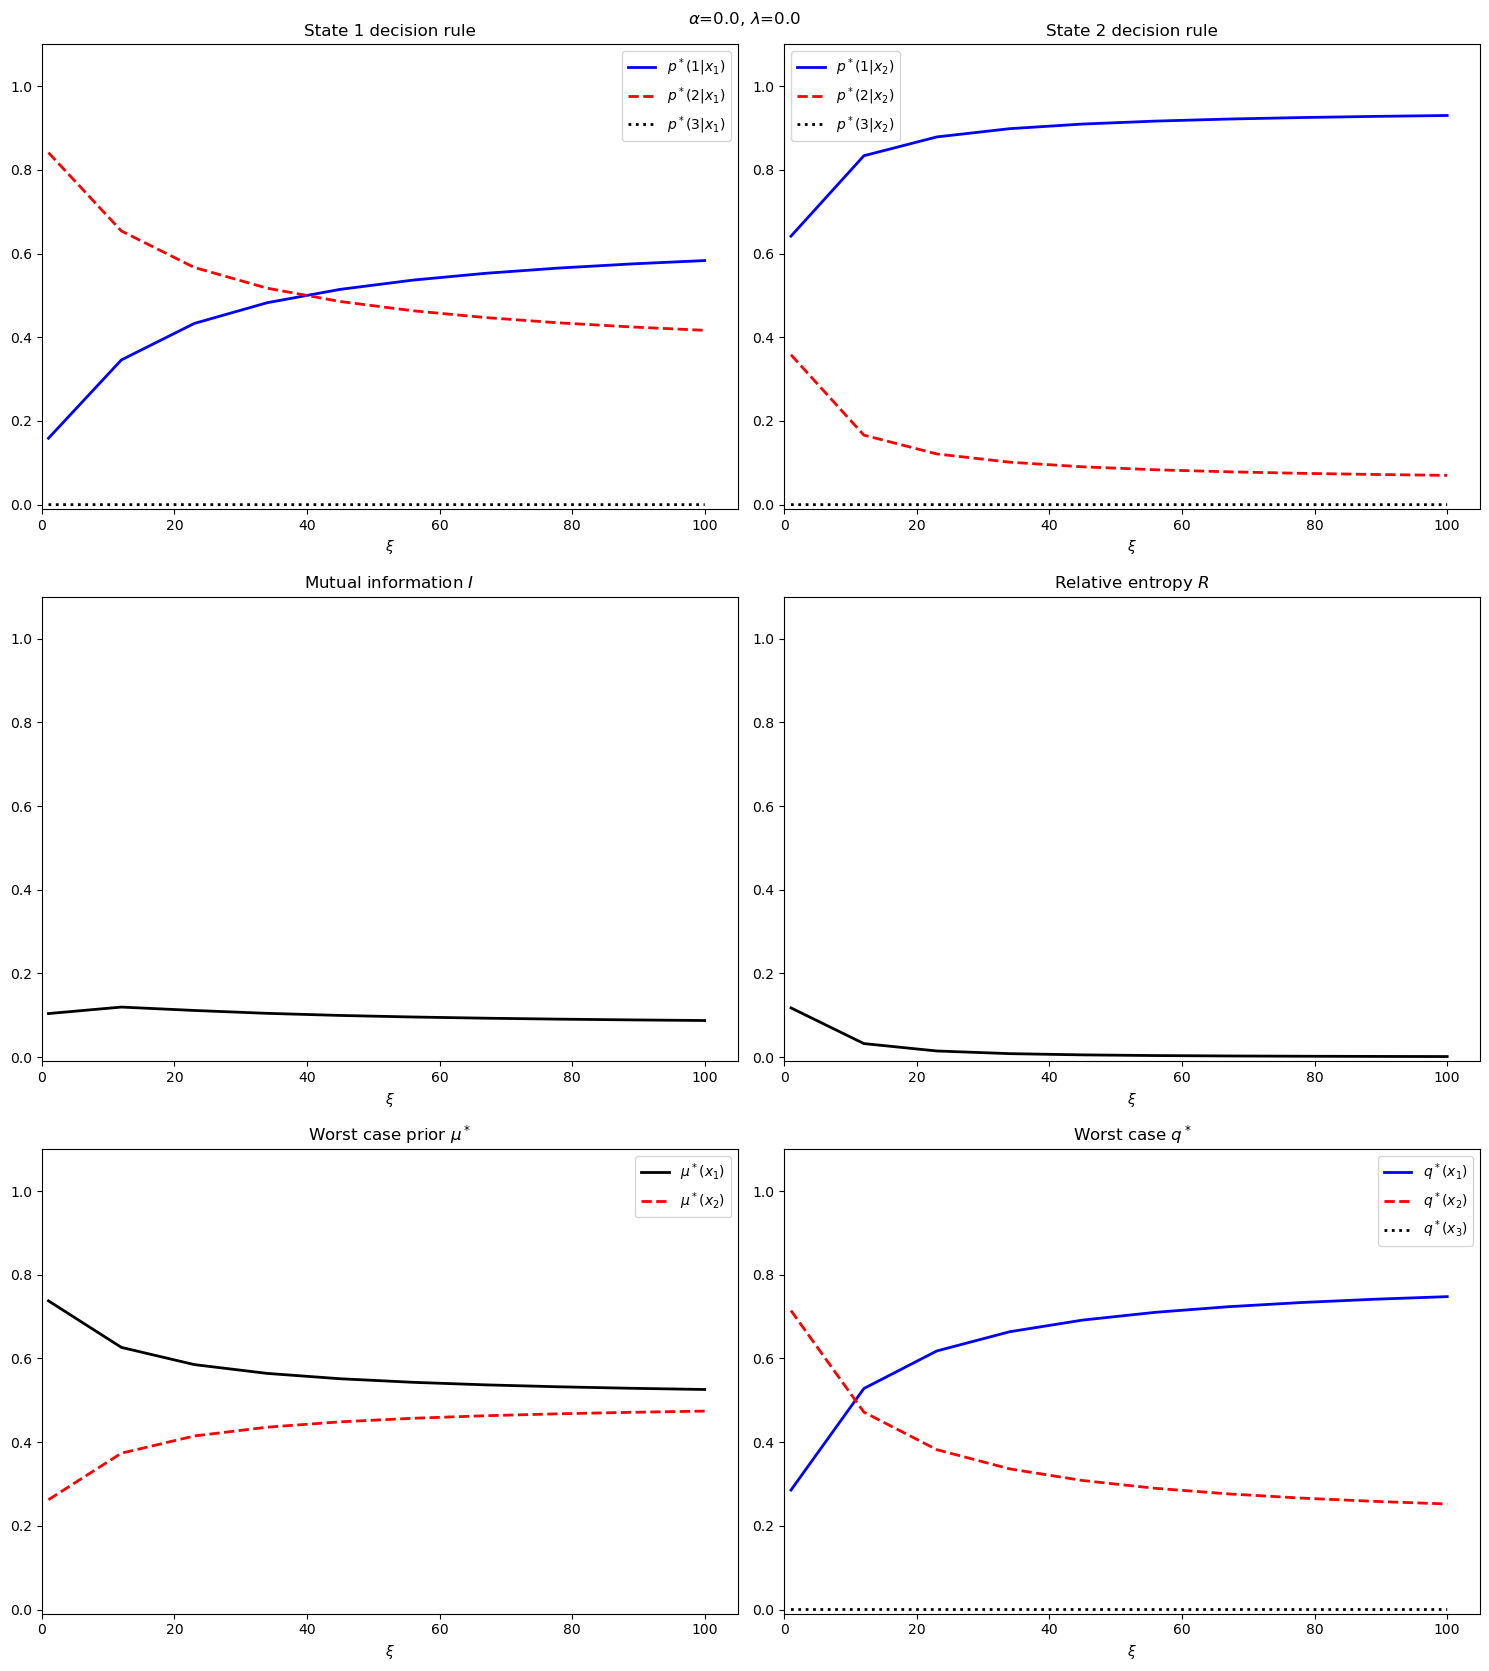

In [26]:
axis = 2
fixed_values = [0,0]
plot_name = 'plot1'
plot(results, alpha_array, Lam_array, xi_array, axis, fixed_values,plot_name)

```{figure} plots/demo_1.png
---
width: 500px
name: demo_1
---
Example figure taken from Figure 2 of the paper.
```

# 2 Mutual Information Constraint
## 2.1 Solution Overview
In the following section, we constrain mutual information and allow $\lambda$ to vary to satisfy this constraint:

$$
\mathbb{I}(p,q) \leq \kappa
$$

To find the optimal $\lambda$, we perform a grid search over `Lam_grid` and find the $\lambda$ which maximises the objective while satisfying the above constraint. This is carried out by the function `find_min_Lam`. Therefore instead of defining `Lam_array`, we define the values of `kappa` for which we want to find a solution and solve for the `implied_lambda`.
```{list-table}
:header-rows: 1

* - Input
  - Type
  - Description
  - Default
* - `kappa_array`
  - *ndarray*
  - Array of **constraints** on mutual information 
  - $[0.04]$
* - `Lam_grid`
  - *ndarray*
  - **Gridpoints** of $\lambda$: this must be sufficiently large to ensure accuracy 
  - 100 evenly spaced points between 1 and 10

## 2.2 Quick Start
First, define the new parameters:

In [21]:
from src import find_min_Lam
kappa_array = np.array([0.04])
Lam_grid = np.linspace(1.0, 10.0, 100)

We also need to define all the previous parameters.

In [ ]:
#Arrays
alpha_array = np.linspace(0.0,0.9, 10)
xi_array = np.linspace(1.0, 100.0, 10)

A, K, X = np.meshgrid(alpha_array, kappa_array, xi_array, indexing='ij')

#Initialize grid of results
results = np.zeros((len(alpha_array), len(kappa_array), len(xi_array)), dtype=object) 
implied_lambda = np.zeros((len(alpha_array), len(kappa_array), len(xi_array)), dtype=float) 

#Parameters
N = 2  # Number of states
M = 3  # Number of actions
r = 7.5 # Parameterization of the payoff set
payoff_set = np.array([[0.0, r * 2], [r, 0.0], [5.0, 5.0]]) # If you want to use the payoff matrix in the paper, do not change this variable; instead, change r
eps = 1e-6  # Error tolerance

# Time-step increments
q_step = 0.1
p_step = 0.1
mu_step = 0.1

# Baseline prior
hat_mu = np.ones(N)*(1/N) # Uniform prior 

# Check that payoff matrix is correctly specified
if payoff_set.shape != (M, N):
    raise ValueError("Payoff set must be of shape (M, N)")

# Collect parameters
params = [M, N, hat_mu, eps, q_step, p_step, mu_step,payoff_set]

Next, we run `find_min_Lam` on our $\lambda$ grid.

In [ ]:
for alpha in range(len(alpha_array)):
    for kappa in range(len(kappa_array)):
        for xi in range(len(xi_array)):
            implied_lambda[alpha,kappa,xi] = find_min_Lam(A[alpha,kappa,xi], K[alpha,kappa,xi], X[alpha,kappa,xi], params,Lam_grid)
            if implied_lambda[alpha,kappa,xi] == None:
                results[alpha,kappa,xi] = None
                results[alpha,kappa,xi]['implied_lambda'] = None
            else:
                results[alpha,kappa,xi] = solve(X[alpha,kappa,xi], implied_lambda[alpha,kappa,xi], A[alpha,kappa,xi], params)
                results[alpha,kappa,xi]['implied_lambda'] = implied_lambda[alpha,kappa,xi]

## 2.3 Plotting
As before, we can use the `plot` function to visualize the solution:

In [ ]:
axis = 2
fixed_values = [0,0]
plot_name = 'plot2'
plot(results, alpha_array, Lam_array, xi_array, axis, fixed_values,plot_name)

```{figure} plots/demo_2.png
---
width: 500px
name: demo_2
---
Example figure taken from Figure 4 of the paper.
```